In [1]:
time_start = dt.now()

### Functions

In [2]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
    }

### 1. Prepare dataset

In [3]:
# read train dataset
df1 = pd.read_csv('data/train.csv')
df1['row_id'] = range(len(df1))

# read test dataset
df2 = pd.read_csv('data/new/test.csv')
df2['row_id'] = range(len(df2))
df2['row_id'] = df2['row_id']  + 1000000

# merge
df = pd.concat([df1,df2])
del df1,df2
gc.collect()

# add fold for splitting
np.random.seed(1234)
df['fold'] = np.random.randint(0,3,len(df))
# drop some features
feats_drop = ['timestamp','active_power_calculated_by_converter','reactice_power_calculated_by_converter']
for f in feats_drop:
    if f in df.columns:
        del df[f]
# label encoder of categorical feats
feats_cat = ['turbine_id']
list_lbl  = []
for f in feats_cat:
    lbl = preprocessing.LabelEncoder()
    df[f] = lbl.fit_transform(df[f])
    list_lbl.append(lbl)

In [4]:
for i,l in enumerate(lbl.classes_):
    print(i, l)

0 Turbine_01
1 Turbine_10
2 Turbine_103
3 Turbine_105
4 Turbine_108
5 Turbine_120
6 Turbine_123
7 Turbine_13
8 Turbine_139
9 Turbine_14
10 Turbine_15
11 Turbine_158
12 Turbine_18
13 Turbine_19
14 Turbine_20
15 Turbine_97


In [5]:
feats_used = [    
    "turbine_id",
    
    "active_power_raw",
    "ambient_temperature",
    "generator_speed",
    "generator_winding_temp_max",
    "grid_power10min_average",
    "nc1_inside_temp",
    "nacelle_temp",
    "reactive_power",
    "wind_direction_raw",
    "wind_speed_raw",
    "wind_speed_turbulence",
  
]

### 2. Training

In [6]:
# Sets creation
feat_target = 'Target'

filt_fold  = df.fold == 0
filt_null  = df[feat_target].isnull()

filt_train = ~filt_fold & ~filt_null
filt_valid = filt_fold & ~filt_null
filt_test  = filt_null

x, y   = df[filt_train][feats_used], df[filt_train][feat_target]
xv, yv = df[filt_valid][feats_used], df[filt_valid][feat_target]
xt, yt = df[filt_test][feats_used],  df[filt_test][feat_target]

print(x.shape, xv.shape, xt.shape)

del df
gc.collect()
x[:3]

(606820, 12) (302784, 12) (303202, 12)


,turbine_id,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
0,4,834.92,31.69,"1,159.62",65.95,917.90,31.88,31.50,165.50,280.86,7.06,0.54
1,12,421.05,12.89,928.75,59.57,445.55,32.42,32.76,113.84,299.55,5.47,0.47
5,10,620.64,28.06,955.60,60.88,697.72,31.01,31.05,75.78,229.57,6.03,0.78


In [7]:
from sklearn import ensemble

model_rf = ensemble.RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
model_rf.fit(x, y)

RandomForestRegressor(max_depth=10, n_jobs=-1)

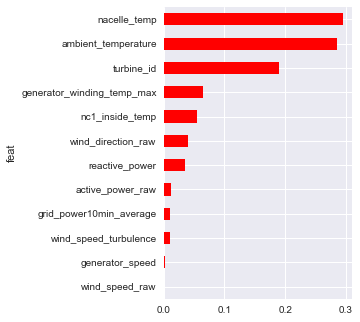

In [14]:
plt.style.use('seaborn')
# feature importances
df_imp = pd.Series(model_rf.feature_importances_, index = feats_used)
df_imp = df_imp/sum(df_imp)
df_imp = df_imp.reset_index()
df_imp.rename(columns={'index':'feat',0:'imp'}, inplace = True)
df_imp = df_imp.sort_values(by = 'imp')
p = df_imp.set_index('feat').imp.plot(kind = 'barh', figsize = (3,5), color = 'red')

In [8]:
pred = model_rf.predict(xv, )
ts_metrics(yv, pred)

{'mae': 0.9996838006669493,
 'mse': 2.187745499416331,
 'mape': 0.021482036399389615,
 'smape': 0.02142772105313926}

In [9]:
# predictions
df_out = pd.DataFrame({
    'Target': pred
})
df_out.to_csv('output/valid_rf.csv', index = False, sep = ',')

df_out = pd.DataFrame({
    'Target': model_rf.predict(xt)
})
df_out.to_csv('output/main_rf.csv', index = False, sep = ',')

In [10]:
print('Working time: ', dt.now() - time_start) 

Working time:  0:01:59.926622
